In [ ]:

!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-odzsb0cm/unsloth_3f59a341175d4c1b8257dfc1142d7a69
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-odzsb0cm/unsloth_3f59a341175d4c1b8257dfc1142d7a69
  Resolved https://github.com/unslothai/unsloth.git to commit 7b4235514af9dbe4bcaf69e5c2453483493c88ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from unsloth import FastLanguageModel
import torch

# Configure model parameters
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load the model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/llama-3-8b-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
# Configure PEFT model
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None
)

Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# Login to Huggingface
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset

# Load the dataset and stream the first example to inspect its structure
dataset = load_dataset("codeparrot/github-code-clean", split="train", streaming=True, trust_remote_code=True)

# Print the first example to check its fields
for example in dataset:
    print(example)
    break


{'code': '\'use strict\';\n\nvar clear          = require(\'es5-ext/array/#/clear\')\n  , eIndexOf       = require(\'es5-ext/array/#/e-index-of\')\n  , setPrototypeOf = require(\'es5-ext/object/set-prototype-of\')\n  , callable       = require(\'es5-ext/object/valid-callable\')\n  , d              = require(\'d\')\n  , ee             = require(\'event-emitter\')\n  , Symbol         = require(\'es6-symbol\')\n  , iterator       = require(\'es6-iterator/valid-iterable\')\n  , forOf          = require(\'es6-iterator/for-of\')\n  , Iterator       = require(\'./lib/iterator\')\n  , isNative       = require(\'./is-native-implemented\')\n\n  , call = Function.prototype.call, defineProperty = Object.defineProperty\n  , SetPoly, getValues;\n\nmodule.exports = SetPoly = function (/*iterable*/) {\n\tvar iterable = arguments[0];\n\tif (!(this instanceof SetPoly)) return new SetPoly(iterable);\n\tif (this.__setData__ !== undefined) {\n\t\tthrow new TypeError(this + " cannot be reinitialized");\n\t}

In [ ]:
# Define the formatting prompt template
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Ensure EOS_TOKEN is added
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(example):
    # Extract fields from the example
    code = example.get("code", "")
    repo_name = example.get("repo_name", "")
    path = example.get("path", "")
    language = example.get("language", "")
    license = example.get("license", "")
    size = example.get("size", "")

    # Create the instruction and input text
    instruction = f"Process the following {language} code from the repository {repo_name}:"
    input_text = f"Path: {path}\nLicense: {license}\nSize: {size}\n\nCode:\n{code}"
    output_text = ""  # Placeholder for expected output or response

    # Format using alpaca_prompt template
    text = alpaca_prompt.format(instruction, input_text, output_text) + EOS_TOKEN
    return {"text": text}

# Load the dataset and only get the first 50 files
from datasets import load_dataset

# Use streaming to load the first 50 files
dataset = load_dataset("codeparrot/github-code-clean", split="train", streaming=True, trust_remote_code=True)

# Limit to the first 50 examples
limited_dataset = []
for i, example in enumerate(dataset):
    if i >= 50:
        break
    formatted_example = formatting_prompts_func(example)
    limited_dataset.append(formatted_example)

# Convert to a dataset object if needed
from datasets import Dataset
formatted_dataset = Dataset.from_dict({"text": [ex["text"] for ex in limited_dataset]})





In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=formatted_dataset,  # Use the formatted dataset
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences.
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
)


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50 | Num Epochs = 10
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.968200
2,1.797400
3,1.634900
4,1.420000
5,1.593500
6,1.062000
7,1.296700
8,0.893900
9,1.008400
10,0.893400


In [ ]:

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1876.0932 seconds used for training.
31.27 minutes used for training.
Peak reserved memory = 9.605 GB.
Peak reserved memory for training = 4.011 GB.
Peak reserved memory % of max memory = 65.127 %.
Peak reserved memory for training % of max memory = 27.197 %.


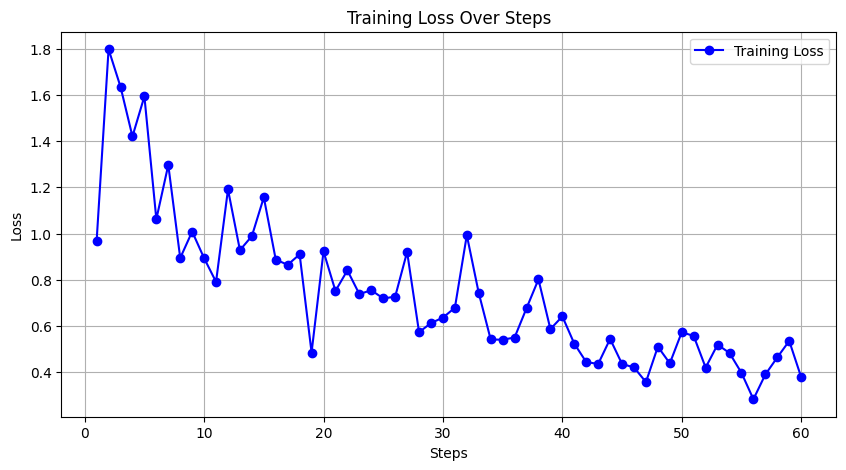

In [ ]:
import matplotlib.pyplot as plt

steps = list(range(1, 61))
loss_values = [
    0.968200, 1.797400, 1.634900, 1.420000, 1.593500, 1.062000, 1.296700, 0.893900,
    1.008400, 0.893400, 0.790600, 1.190500, 0.928000, 0.988800, 1.156500, 0.887000,
    0.864700, 0.909700, 0.485100, 0.922500, 0.751600, 0.840600, 0.738000, 0.754600,
    0.719100, 0.726700, 0.920200, 0.573000, 0.612500, 0.636100, 0.678700, 0.992700,
    0.742500, 0.541500, 0.540500, 0.550000, 0.676800, 0.801500, 0.586400, 0.641400,
    0.523500, 0.443900, 0.435600, 0.543800, 0.435500, 0.420700, 0.357100, 0.510300,
    0.438300, 0.573000, 0.556700, 0.419900, 0.519400, 0.482800, 0.397100, 0.283000,
    0.390000, 0.464000, 0.535200, 0.378500
]

# Draw the loss curve
plt.figure(figsize=(10, 5))
plt.plot(steps, loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")


('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')